### LIBRERÍAS

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from feature_engine.encoding import RareLabelEncoder,OneHotEncoder

### FUNCIONES

In [2]:
def data_year(year):
    """Función que almacena la info del año ingresado"""
    path = 'Data/'
    content = os.listdir(path)
    data_list = []
    for folder in content:
        try:
            if folder.index(year) > 0:
                content_l2 = os.listdir(f'{path}{folder}/')
                for folder2 in content_l2:
                    try:
                        if folder2.index('sdem') > 0:
                            path2 = f'{path}{folder}/{folder2}/conjunto_de_datos/'
                            content_l3 = os.listdir(f'{path2}')
                            #print(f'{path2}{content_l3[0]}')
                            data = pd.read_csv(f'{path2}{content_l3[0]}',
                                               encoding='latin',
                                               usecols = ['R_DEF','ENT','PAR_C','SEX','EDA','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','N_HIJ',
                                                          'E_CON','UR','CLASE1','CLASE2','HRSOCUP','HRSOCUP','INGOCUP']) 
                            # Variables descartadas: 'NAC_ANIO','EMP_PPAL','PER','ZONA','CS_P17'
                            #print('original',len(data), data.shape)
                            data = data[data['R_DEF']==0]
                            # Filtra los datos de interés
                            #print('completo',len(data))
                            data = data[(data['CS_P13_1']==7)|(data['CS_P13_1']==8)|(data['CS_P13_1']==9)]
                            #print('licenciaturas',len(data))
                            data_list.append(data)
                    except:
                        next
        except:
            next
    return pd.concat(data_list)

### EXTRACCIÓN DE LA INFORMACIÓN

In [3]:
data2018 = data_year('2018')

C:\Users\renat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
data2019 = data_year('2019')

In [5]:
data2020 = data_year('2020')

In [6]:
data = pd.concat([data2018,data2019,data2020],ignore_index=True)

In [7]:
data.to_csv('data.csv')

### REVISIÓN DEL DATA SET

In [8]:
data.shape

(473423, 16)

In [9]:
data.columns

Index(['R_DEF', 'ENT', 'PAR_C', 'SEX', 'EDA', 'L_NAC_C', 'CS_P13_1',
       'CS_P14_C', 'CS_P16', 'N_HIJ', 'E_CON', 'UR', 'CLASE1', 'CLASE2',
       'HRSOCUP', 'INGOCUP'],
      dtype='object')

In [10]:
data.dtypes

R_DEF         int64
ENT           int64
PAR_C       float64
SEX         float64
EDA         float64
L_NAC_C     float64
CS_P13_1    float64
CS_P14_C     object
CS_P16      float64
N_HIJ       float64
E_CON       float64
UR            int64
CLASE1        int64
CLASE2        int64
HRSOCUP       int64
INGOCUP       int64
dtype: object

In [11]:
data = data.convert_dtypes()

In [12]:
#to_int = ['PAR_C','SEX','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','CS_P17','N_HIJ','E_CON']
#for col in to_int:
#    data[col] = pd.to_numeric(data[col],downcast='integer',errors= 'coerce')

In [13]:
data.dtypes

R_DEF        Int64
ENT          Int64
PAR_C        Int64
SEX          Int64
EDA          Int64
L_NAC_C      Int64
CS_P13_1     Int64
CS_P14_C    string
CS_P16       Int64
N_HIJ        Int64
E_CON        Int64
UR           Int64
CLASE1       Int64
CLASE2       Int64
HRSOCUP      Int64
INGOCUP      Int64
dtype: object

### DEFINICIÓN DE VARIABLE OBJETIVO

In [14]:
# Defino campo target
pd.pivot_table(data,index = ['CLASE1','CLASE2'], values = ['HRSOCUP','INGOCUP'], aggfunc = 'mean')

HRSOCUP      INGOCUP
CLASE1 CLASE2                        
1      1       38.635385  6360.559097
       2        0.000000     0.000000
2      3        0.000000     0.000000
       4        0.000000     0.000000

In [15]:
# Clase1:
# 1 PEA, 
# 2 PNEA
# Personas de 12 años y más que durante el periodo de referencia no tuvieron ni realizaron una actividad 
# económica, ni buscaron desempeñar una en el último mes previo al día de la entrevista.
# Clase2: 
#  1 PoblaciÃ³n ocupada
#  2 PoblaciÃ³n desocupada
#  3 Disponibles
#  4 No disponibles
data['TARGET'] = np.where((data['CLASE1'] == 1)&(data['CLASE2'] == 1),1,0)
# 1 Ejerce
# 0 No Ejerce

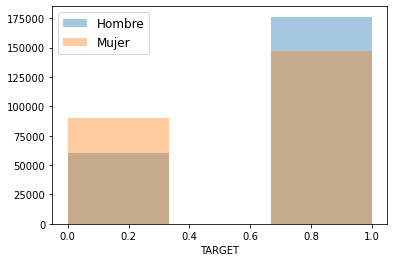

In [16]:
sns.distplot(data[data['SEX']==1]['TARGET'], bins = 3, label='Hombre', kde = False)
sns.distplot(data[data['SEX']==2]['TARGET'], bins = 3, label='Mujer', kde = False)
plt.legend(prop={'size': 12})
plt.show()

In [17]:
#Para evitar colinealidad elimino las 2 columnas que me sirvieron para definir mi columna TARGET
# Aporvecho para eliminar R_DEF que sólo me ayudó a filtrar la info completa
data.drop(['CLASE1','CLASE2', 'R_DEF'], axis=1, inplace=True)

### REVISIÓN DE NULOS

In [18]:
data.isnull().sum()

ENT              0
PAR_C            0
SEX              0
EDA              0
L_NAC_C          0
CS_P13_1         0
CS_P14_C         0
CS_P16           0
N_HIJ       236700
E_CON            0
UR               0
HRSOCUP          0
INGOCUP          0
TARGET           0
dtype: int64

In [19]:
# Revisando si hay algún tipo de relación con el parentezco, 
# encontré que la categoría 101, 301, 409 corresponde a "Jefa o jefe, vive sola o solo", "Hija o hijo", "Nieta o nieto" asumiendo que no tienen hijos
# y la categoría 417 corresponden "Nuera o yerno",  
# por lo que se asume que al menos tiene un hijo o hija.
data[data['N_HIJ'].isnull()]['PAR_C'].value_counts()

101    127219
301     81511
201      8399
417      4483
409      4167
403      3290
501      2979
413      2037
418       740
414       523
303       474
401       452
415       143
412       107
421        41
302        35
402        23
419        21
410        20
202        16
999         6
701         5
406         3
423         2
405         1
420         1
422         1
615         1
Name: PAR_C, dtype: Int64

In [20]:
# Asigno un 0 en N_HIJ a los que cumplen con esta característica 
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 101),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 301),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 409),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 417),'N_HIJ'] = 1

In [21]:
data.isnull().sum()

ENT             0
PAR_C           0
SEX             0
EDA             0
L_NAC_C         0
CS_P13_1        0
CS_P14_C        0
CS_P16          0
N_HIJ       19320
E_CON           0
UR              0
HRSOCUP         0
INGOCUP         0
TARGET          0
dtype: int64

In [22]:
# Dado que aún quedaron nulos que no fue posible asignar y que represnetan sólo un 4% del total, decido eliminarlos
data.isnull().sum()['N_HIJ'] / len(data)

0.040809170657107915

In [23]:
data = data.dropna()

In [24]:
# Finalmente la variable PAR_C sólo la necesitaba para aisgnar el número de hijos, por lo que ya la puedo eliminar
data.drop('PAR_C', axis=1, inplace = True)

### REVISIÓN DE VARIABLES

In [25]:
numerics = ['HRSOCUP','INGOCUP','EDA']
categories = data.drop(['HRSOCUP','INGOCUP','EDA','TARGET'],axis=1).columns

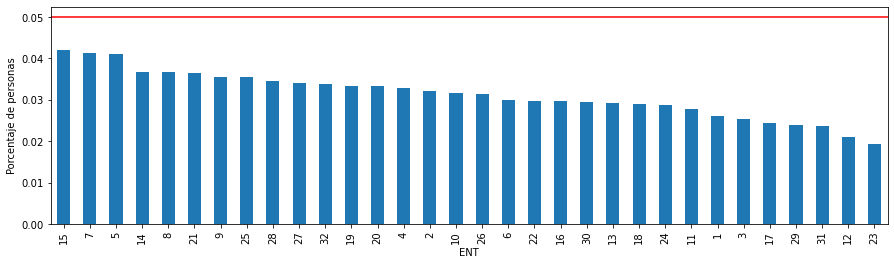

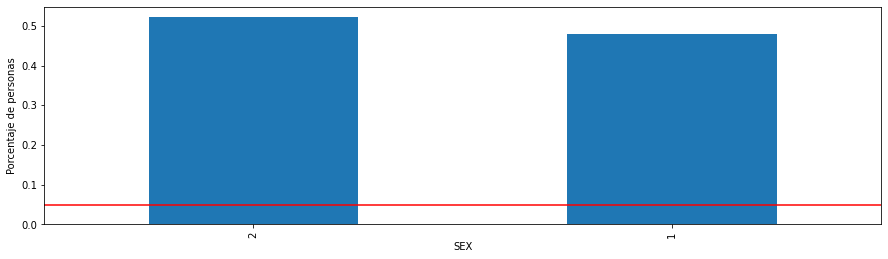

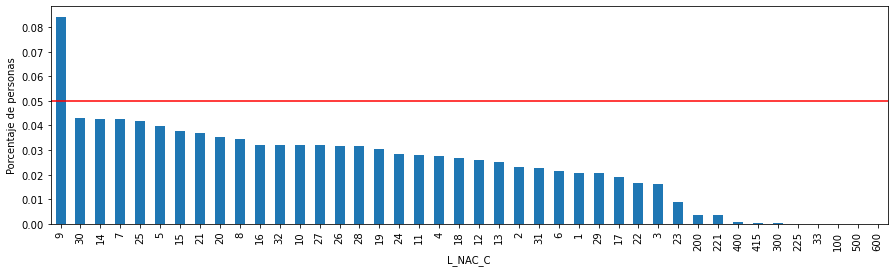

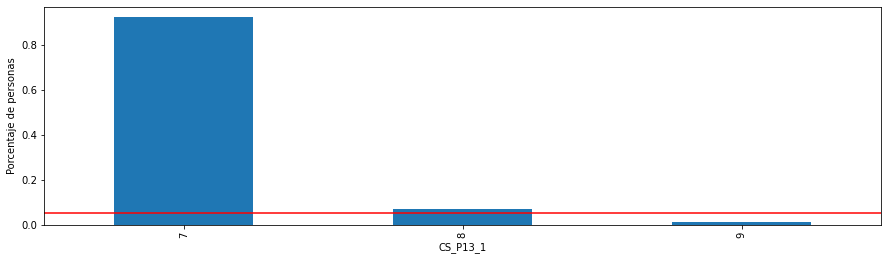

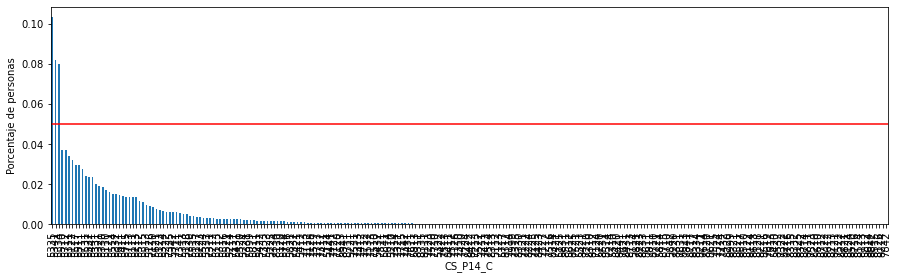

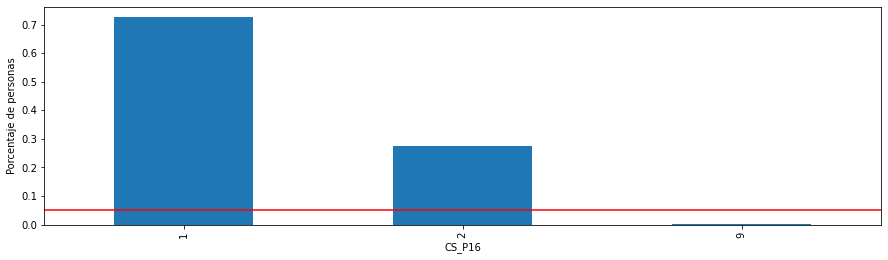

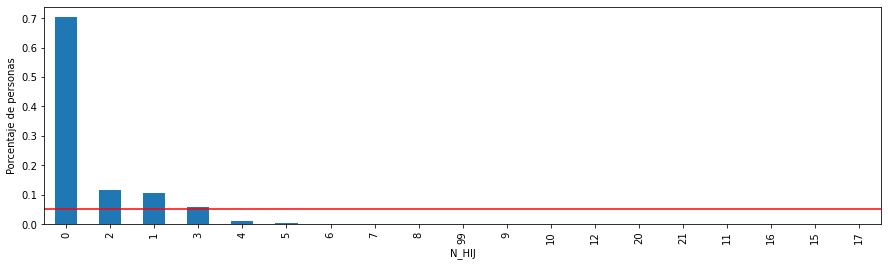

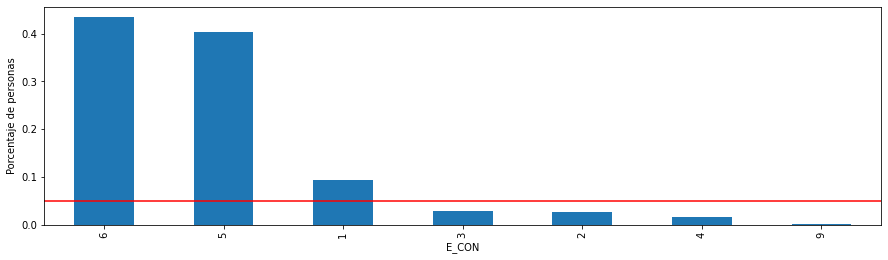

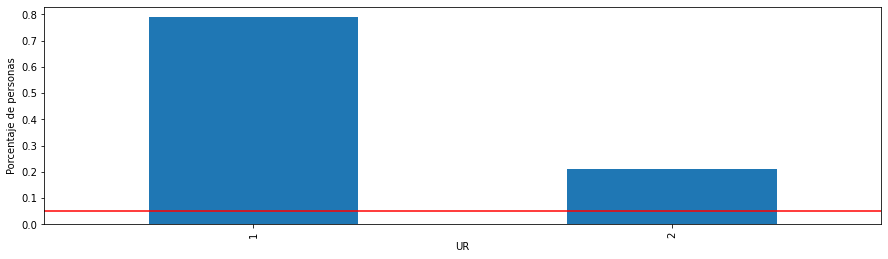

In [26]:
for col in categories:
    temp_df = pd.Series(data[col].value_counts() / len(data))
    plt.figure(figsize = (15,4))
    fig = temp_df.sort_values(ascending = False).plot.bar()
    fig.set_xlabel(col)
    
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Porcentaje de personas')
    plt.show()

In [27]:
# Dado que hay una numerosa cantidad de códigos de carreras, lo reduzco al campo de las mismas
# Genero un diccionario con los campos amplios de las carreras de la Clasificación de Mexicana de Programas de Estudio (CMPE):
carrera = {'1':'Educación', 
           '2':'Artes y humanidades',
           '3':'Ciencias sociales, administración y derecho',
           '4':'Ciencias naturales, exactas y de la computación',
           '5':'Ingeniería, manufactura y construcción',
           '6':'Agronomía y veterinaria',
           '7':'Salud',
           '8':'Servicios',
           '9':'No especificado'}

In [28]:
data['CAMPO'] = pd.to_numeric(data['CS_P14_C'].apply(lambda x: x[1:2]))
#carrera[data.loc[:,'CS_P14_C'][1:2]]
data['CAMPO'].value_counts()

3    199971
5     91880
1     58372
7     47944
4     23677
2     17723
6     11325
8      2171
9      1040
Name: CAMPO, dtype: int64

In [29]:
data.drop('CS_P14_C', axis=1, inplace = True)

In [30]:
# Creación de columna para determinar si la entidad donde se toma la encuesta es la misma que la de nacimiento y determinar si se tuvo que mudar
data['ENT_ORIGEN'] = np.where(data['ENT'] == data['L_NAC_C'], 1, 0)
data['ENT_ORIGEN'].value_counts()

1    358478
0     95625
Name: ENT_ORIGEN, dtype: int64

In [31]:
# Dropeamos las columnas 'ENT' y 'L_NAC_C'
data.drop(['ENT','L_NAC_C'], axis=1, inplace = True)

In [32]:
# EL 99 en la columna N_HIJ implica que no se proporcionó ibnformación por lo que se eliminan estos registros
data = data[data['N_HIJ']!=99]

In [33]:
# Revisión de variables númericas
data[numerics].describe()

,HRSOCUP,INGOCUP,EDA
count,454079.000000,454079.000000,454079.000000
mean,26.190870,4329.077890,37.479271
std,22.725113,7766.034918,14.279818
min,0.000000,0.000000,16.000000
25%,0.000000,0.000000,26.000000
50%,30.000000,0.000000,34.000000
75%,45.000000,7200.000000,47.000000
max,168.000000,300000.000000,98.000000


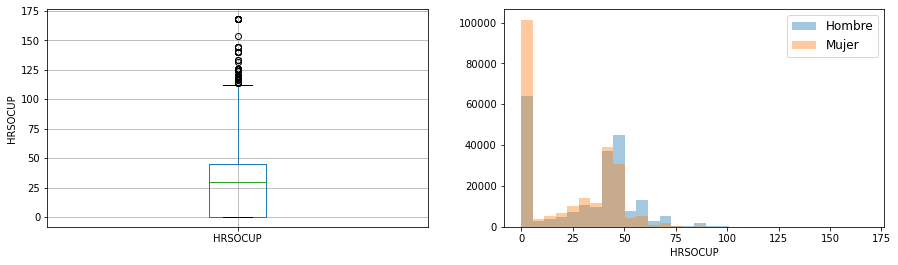

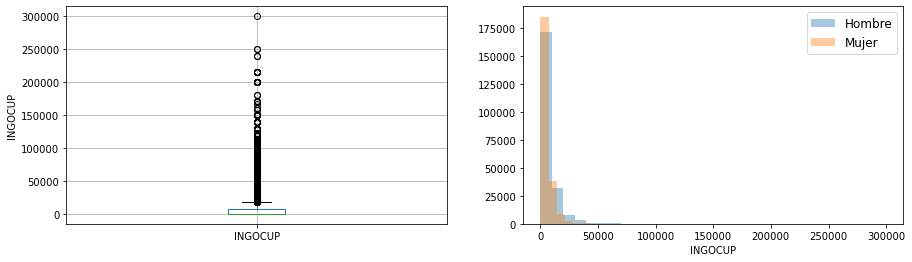

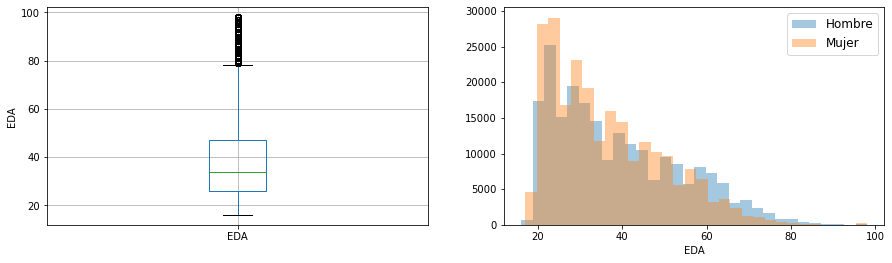

In [34]:
for col in numerics:
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    fig = data.boxplot(column = col)
    fig.set_ylabel(col)
    
    plt.subplot(1,2,2)
    fig = sns.distplot(data[data['SEX']==1][col], bins = 30, label='Hombre', kde = False)
    fig = sns.distplot(data[data['SEX']==2][col], bins = 30, label='Mujer', kde = False) #data[col].hist(bins = 30)
    plt.legend(prop={'size': 12})
    fig.set_xlabel(col)
    plt.show()

In [35]:
# Definimos el rango de edad de interés de los 20 a los 50  y sleccionamos los datos quedndome con el 75% del total del sataset
data_len = len(data)
data = data[(data['EDA']>20)&(data['EDA']<=50)]
len(data)/data_len

0.7493585917868917

### REVISIÓN DE COLINEARIDAD

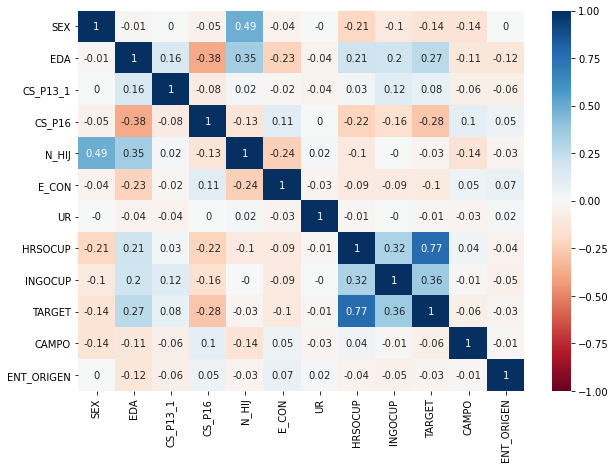

In [36]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr().round(2),  
           vmin = -1,
           vmax = 1,
           cmap = 'RdBu',
           annot =True);
# EMP_ PPAL, no hrs principal sólo con las posibles características

In [37]:
# Dada la alta coreralción de las variables de hora e ingreso, las elimino
data_final = data.drop(['HRSOCUP','INGOCUP'], axis=1)
data_final['N_HIJ'] = data_final['N_HIJ'].astype("object")

In [38]:
data_final.to_csv('data_final.csv')

In [39]:
X = data_final.drop('TARGET', axis=1) 
y = data_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [40]:
X.dtypes

SEX            Int64
EDA            Int64
CS_P13_1       Int64
CS_P16         Int64
N_HIJ         object
E_CON          Int64
UR             Int64
CAMPO          int64
ENT_ORIGEN     int32
dtype: object

In [41]:
data_pipeline = Pipeline([('rare_label_enc', RareLabelEncoder(tol=0.05, n_categories=6, variables=['N_HIJ'], replace_with='5')),
                         ('MinMaxScaler', MinMaxScaler())
                        ])

In [42]:
X_train_trans = data_pipeline.fit_transform(X_train)
X_test_trans = data_pipeline.transform(X_test)

In [43]:
X_eval_trans = data_pipeline.transform(X_eval)

### LinearRegression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,roc_auc_score

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train_trans, y_train)

LogisticRegression()

In [46]:
y_pred_test = lr_model.predict(X_test_trans)

In [47]:
confusion_matrix(y_test, y_pred_test)

array([[ 4596, 13184],
       [ 2899, 47375]], dtype=int64)

In [48]:
accuracy_score(y_test, y_pred_test)

0.7636729655861522

0.7452041183269563

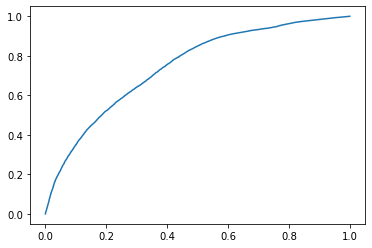

In [49]:
from sklearn import metrics
 
y_pred_proba = lr_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [50]:
# Check overfitting
y_train_pred = lr_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 17772,  52734],
       [ 11753, 189955]], dtype=int64)

In [51]:
accuracy_score(y_train, y_train_pred)

0.7631018242999993

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf_model = RandomForestClassifier()

In [54]:
parameters = {
    'n_estimators': np.arange(10, 300, 150),
    'max_depth': np.arange(6,10,1),
}
gs = GridSearchCV(rf_model, parameters)
gs.fit(X_eval_trans, y_eval)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([6, 7, 8, 9]),
                         'n_estimators': array([ 10, 160])})

In [55]:
gs.best_params_, gs.best_score_

({'max_depth': 9, 'n_estimators': 10}, 0.7853303128635278)

In [56]:
best_params = gs.best_params_
#best_params = {'max_depth': 9, 'n_estimators': 160}

In [57]:
rf_model.set_params(**best_params)
rf_model.fit(X_train_trans, y_train)

RandomForestClassifier(max_depth=9, n_estimators=160)

In [58]:
y_pred_test = rf_model.predict(X_test_trans)

In [59]:
confusion_matrix(y_test, y_pred_test)

array([[ 6350, 11430],
       [ 3344, 46930]], dtype=int64)

In [60]:
accuracy_score(y_test, y_pred_test)

0.7829076909513034

0.7831487671407704

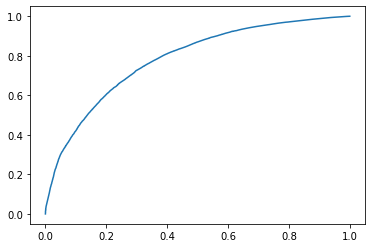

In [61]:
y_pred_proba = rf_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [62]:
# Check overfitting
y_train_pred = rf_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 25404,  45102],
       [ 13290, 188418]], dtype=int64)

In [63]:
accuracy_score(y_train, y_train_pred)

0.7854922965020168

### Gaussian Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB

In [65]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_trans, y_train)

GaussianNB()

In [66]:
y_pred_test = gnb_model.predict(X_test_trans)

In [67]:
confusion_matrix(y_test, y_pred_test)

array([[ 8761,  9019],
       [ 7875, 42399]], dtype=int64)

In [68]:
accuracy_score(y_test, y_pred_test)

0.7517559585035413

0.7254116877083884

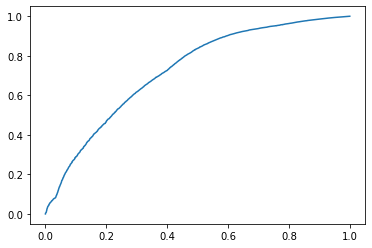

In [69]:
y_pred_proba = gnb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [70]:
# Check overfitting
y_train_pred = gnb_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 34783,  35723],
       [ 31458, 170250]], dtype=int64)

In [71]:
accuracy_score(y_train, y_train_pred)

0.7532051988509041

### K-Nearest Neighbors

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_trans, y_train)

KNeighborsClassifier()

In [74]:
y_pred_test = knn_model.predict(X_test_trans)

In [75]:
confusion_matrix(y_test, y_pred_test)

array([[ 7507, 10273],
       [ 6230, 44044]], dtype=int64)

In [76]:
accuracy_score(y_test, y_pred_test)

0.7575013959502748

0.7302564874745114

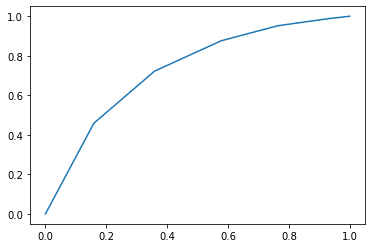

In [77]:
y_pred_proba = knn_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [78]:
# Check overfitting
y_train_pred = knn_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 32156,  38350],
       [ 22824, 178884]], dtype=int64)

In [79]:
accuracy_score(y_train, y_train_pred)

0.7752723959825726

### Gradient Boosting

In [80]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier()

In [81]:
parameters = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth':np.arange(4, 10, 1),
    'n_estimators': np.arange(10, 100, 10)}

gs = GridSearchCV(lgbm_model, parameters)
gs.fit(X_eval_trans, y_eval, verbose=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [82]:
gs.best_params_, gs.best_score_

({'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 50},
 0.7861507377701586)

In [83]:
best_params = gs.best_params_
#best_params = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 90}

In [84]:
# Los seleccionamos y entrenamos un modelo con estos valores
lgbm_model.set_params(**best_params)
lgbm_model.fit(X_train_trans, y_train)

LGBMClassifier(learning_rate=0.2, max_depth=9, n_estimators=50)

In [85]:
y_test_pred = lgbm_model.predict(X_test_trans)

In [86]:
confusion_matrix(y_test, y_test_pred)

array([[ 6612, 11168],
       [ 3597, 46677]], dtype=int64)

In [87]:
accuracy_score(y_test, y_test_pred)

0.7830399388720721

0.7854879159841861

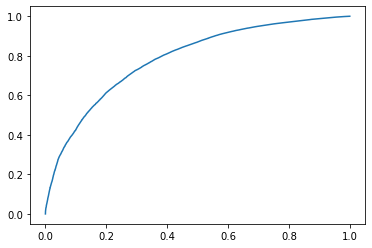

In [88]:
y_pred_proba = lgbm_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [89]:
# Check overfitting
y_train_pred = lgbm_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 26385,  44121],
       [ 14269, 187439]], dtype=int64)

In [90]:
accuracy_score(y_train, y_train_pred)

0.7854996436627065

### CatBoostClassifier

In [91]:
from catboost import CatBoostClassifier

In [92]:
cb_model = CatBoostClassifier(iterations = 5000)

In [93]:
cb_model.fit(X_train_trans, y_train)

Learning rate set to 0.025804
0:	learn: 0.6798172	total: 220ms	remaining: 18m 18s
1:	learn: 0.6674164	total: 271ms	remaining: 11m 16s
2:	learn: 0.6556665	total: 314ms	remaining: 8m 42s
3:	learn: 0.6445823	total: 354ms	remaining: 7m 22s
4:	learn: 0.6342310	total: 393ms	remaining: 6m 32s
5:	learn: 0.6244679	total: 445ms	remaining: 6m 10s
6:	learn: 0.6152681	total: 499ms	remaining: 5m 56s
7:	learn: 0.6067736	total: 545ms	remaining: 5m 40s
8:	learn: 0.5993330	total: 587ms	remaining: 5m 25s
9:	learn: 0.5919228	total: 631ms	remaining: 5m 14s
10:	learn: 0.5848539	total: 688ms	remaining: 5m 11s
11:	learn: 0.5782976	total: 741ms	remaining: 5m 7s
12:	learn: 0.5721235	total: 794ms	remaining: 5m 4s
13:	learn: 0.5666108	total: 845ms	remaining: 5m 1s
14:	learn: 0.5615789	total: 905ms	remaining: 5m
15:	learn: 0.5567848	total: 956ms	remaining: 4m 57s
16:	learn: 0.5518835	total: 1s	remaining: 4m 54s
17:	learn: 0.5475784	total: 1.07s	remaining: 4m 55s
18:	learn: 0.5431957	total: 1.12s	remaining: 4m 54s


In [94]:
y_test_pred = cb_model.predict(X_test_trans)

In [95]:
confusion_matrix(y_test, y_test_pred)

array([[ 6850, 10930],
       [ 3735, 46539]], dtype=int64)

In [96]:
accuracy_score(y_test, y_test_pred)

0.7845093602139478

0.7882111585317858

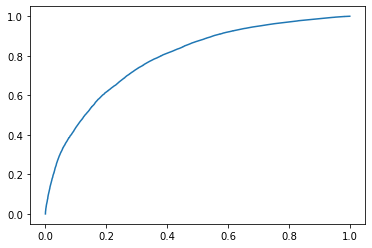

In [97]:
y_pred_proba = cb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [98]:
data_results = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop = True),pd.Series(y_test_pred)], axis=1)

In [99]:
data_results[data_results['TARGET']!=data_results[0]]

,SEX,EDA,CS_P13_1,CS_P16,N_HIJ,E_CON,UR,CAMPO,ENT_ORIGEN,TARGET,0
15,1,24,7,2,0,6,1,2,1,1,0
20,1,25,7,2,0,6,1,5,1,0,1
23,1,29,7,1,0,6,1,3,1,0,1
25,2,39,8,1,1,5,1,3,0,0,1
30,2,39,7,1,2,5,2,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
68026,1,22,7,2,0,6,1,3,0,1,0
68033,1,21,7,2,0,6,1,5,1,1,0
68035,2,40,7,2,2,5,1,3,0,0,1
68046,1,21,7,1,0,6,1,3,1,0,1
